In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import random
import os
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import pandas as pd

In [2]:
# Directories for training and testing
train_dir = "/kaggle/input/animal-breed-dataset/animal_breed_classification/TRAIN"
test_dir = "/kaggle/input/animal-breed-dataset/animal_breed_classification/TEST"

In [3]:
# Advanced data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split 20% for validation
)

# Creating training and validation data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4730 images belonging to 37 classes.
Found 1160 images belonging to 37 classes.


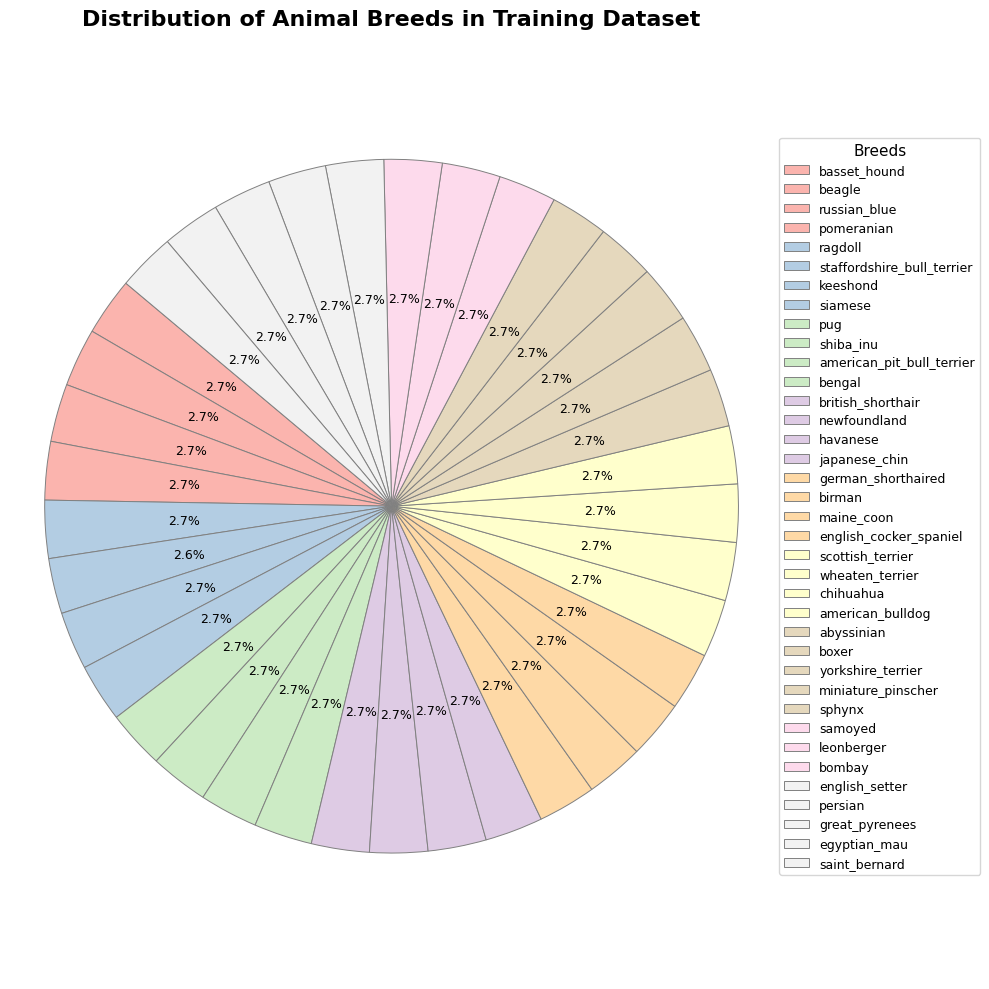

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the training directory
train_dir = "/kaggle/input/animal-breed-dataset/animal_breed_classification/TRAIN"
# Count images in each breed directory
breed_counts = {}
for breed in os.listdir(train_dir):
    breed_path = os.path.join(train_dir, breed)
    if os.path.isdir(breed_path):  # Check if it is a directory
        breed_counts[breed] = len(os.listdir(breed_path))  # Count images

# Calculate total images and percentages for each breed
total_images = sum(breed_counts.values())
percentages = [(count / total_images) * 100 for count in breed_counts.values()]

# Create a pie chart with a muted color palette
plt.figure(figsize=(10, 10), facecolor='white')
colors = plt.cm.Pastel1(np.linspace(0, 1, len(breed_counts)))  # Use 'Pastel1' for softer colors

# Custom function to format percentage out of 100
def func(pct):
    return f'{pct:.1f}%'  # Display the percentage to one decimal place

# Plot pie chart with optimized aesthetics
wedges, texts, autotexts = plt.pie(
    percentages,
    labels=None,  # Labels will go in the legend for clarity
    autopct=func,  # Use custom function for percentages
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'gray', 'linewidth': 0.7}  # Use lighter edge colors
)

# Title and styling
plt.title('Distribution of Animal Breeds in Training Dataset', fontsize=16, fontweight='bold', color='black')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Create legend with breed names and their colors
plt.legend(
    wedges, breed_counts.keys(),
    title="Breeds",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=9,
    title_fontsize='11'
)

# Adjust the appearance of the percentage labels inside the pie slices
for autotext in autotexts:
    autotext.set_size(9)
    autotext.set_color('black')

# Display the pie chart
plt.tight_layout()
plt.show()

In [5]:
# Learning rate reduction and model checkpoint setup
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
callbacks = [lr_scheduler, checkpoint]


In [6]:
def create_model(base_model):
    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    predictions = Dense(train_data.num_classes, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
def train_model(model, model_name):
    print(f"Training {model_name}...")
    # Train the model
    history = model.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks=callbacks
    )
    
    # Store the training history
    results[model_name] = history
    return history


In [8]:
# Dictionary to store model results for comparison
results = {}

# List of models to train
models = {
    'EfficientNetB0': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'InceptionV3': InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'MobileNetV2': MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Train and evaluate each model
for model_name, base_model in models.items():
    model = create_model(base_model)
    train_model(model, model_name)


Training EfficientNetB0...
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730734201.451100     114 service.cc:145] XLA service 0x7b108c0049c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730734201.451179     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730734201.451185     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730734252.306497     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4315 - loss: 2.1003
Epoch 1: val_accuracy improved from -inf to 0.02672, saving model to best_model.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.4327 - loss: 2.0955 - val_accuracy: 0.0267 - val_loss: 3.6749 - learning_rate: 0.0010
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.7894 - loss: 0.6621
Epoch 2: val_accuracy improved from 0.02672 to 0.02759, saving model to best_model.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 97s 630ms/step - accuracy: 0.7894 - loss: 0.6621 - val_accuracy: 0.0276 - val_loss: 3.6896 - learning_rate: 0.0010
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8375 - loss: 0.5105
Epoch 3: val_accuracy did not improve from 0.02759
148/148 ━━━━━━━━━━━━━━━━━━━━ 98s 635ms/step - accuracy: 0.8375 - loss: 0.5105 - val_accuracy: 0.0276 - val_loss: 3.7435 - learning_rate: 0.0010
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8527 - loss: 0.4456
Epoch 

I0000 00:00:1730737373.701119     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_24', 20 bytes spill stores, 20 bytes spill loads



148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.1474 - loss: 3.4054
Epoch 1: val_accuracy did not improve from 0.90431
148/148 ━━━━━━━━━━━━━━━━━━━━ 213s 995ms/step - accuracy: 0.1479 - loss: 3.4020 - val_accuracy: 0.0276 - val_loss: 5.3897 - learning_rate: 0.0010
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.4065 - loss: 2.0065
Epoch 2: val_accuracy did not improve from 0.90431
148/148 ━━━━━━━━━━━━━━━━━━━━ 109s 711ms/step - accuracy: 0.4066 - loss: 2.0060 - val_accuracy: 0.0276 - val_loss: 4.7668 - learning_rate: 0.0010
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.5046 - loss: 1.5988
Epoch 3: val_accuracy did not improve from 0.90431
148/148 ━━━━━━━━━━━━━━━━━━━━ 110s 722ms/step - accuracy: 0.5048 - loss: 1.5986 - val_accuracy: 0.0267 - val_loss: 4.3379 - learning_rate: 0.0010
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.5909 - loss: 1.3453
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487

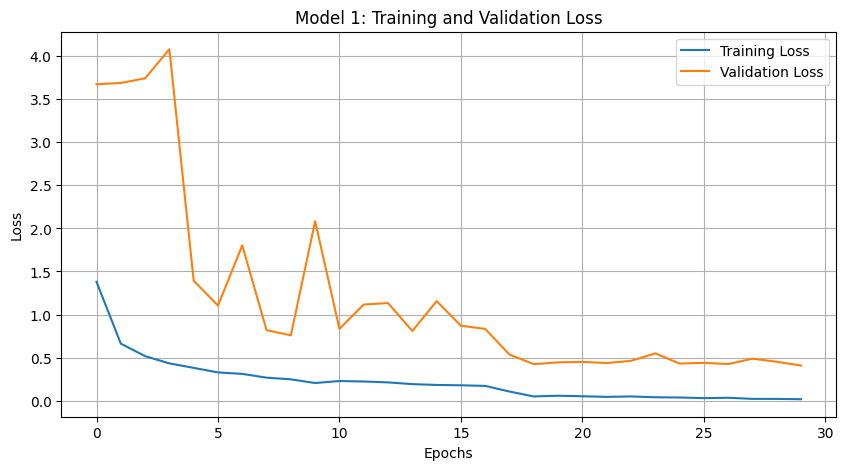

In [10]:
# Plot training and validation loss for Model 1
plt.figure(figsize=(10, 5))
plt.plot(results['EfficientNetB0'].history['loss'], label='Training Loss')
plt.plot(results['EfficientNetB0'].history['val_loss'], label='Validation Loss')
plt.title('Model 1: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


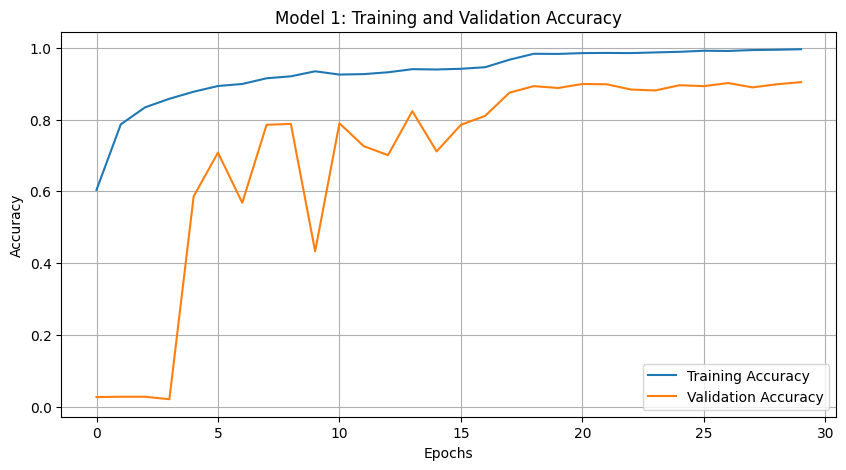

In [11]:
# Plot training and validation accuracy for Model 1
plt.figure(figsize=(10, 5))
plt.plot(results['EfficientNetB0'].history['accuracy'], label='Training Accuracy')
plt.plot(results['EfficientNetB0'].history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


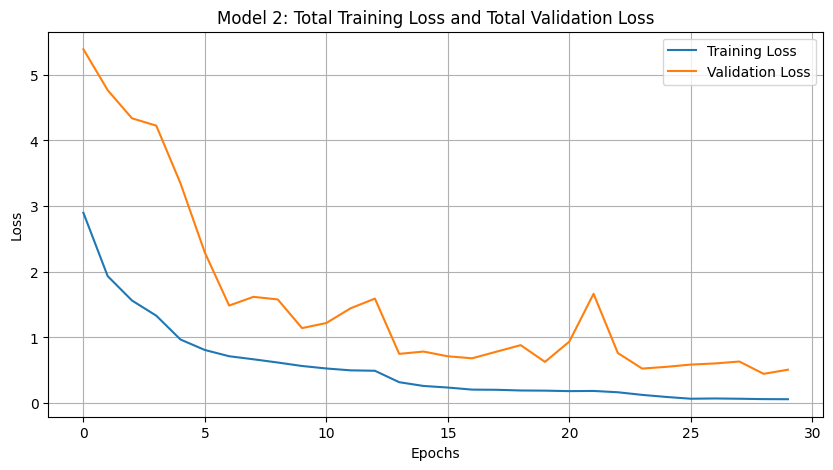

In [12]:
# Plot training and validation loss for Model 2
plt.figure(figsize=(10, 5))
plt.plot(results['ResNet50'].history['loss'], label='Training Loss')
plt.plot(results['ResNet50'].history['val_loss'], label='Validation Loss')
plt.title('Model 2: Total Training Loss and Total Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


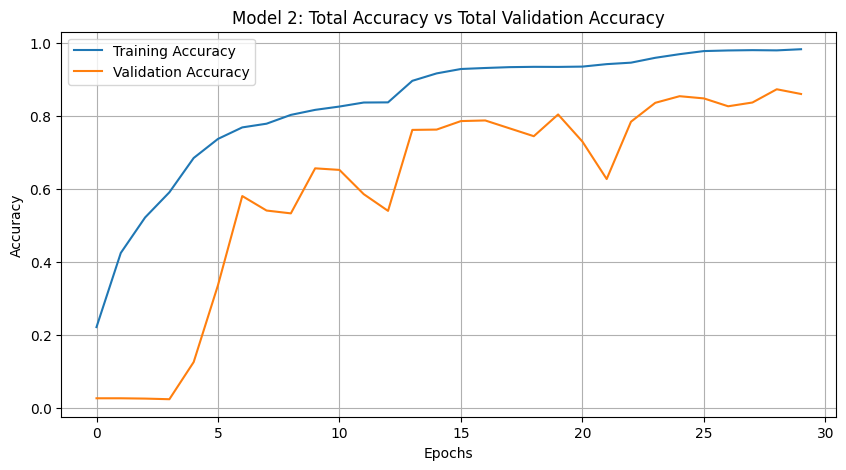

In [13]:
# Plot training and validation accuracy for Model 2
plt.figure(figsize=(10, 5))
plt.plot(results['ResNet50'].history['accuracy'], label='Training Accuracy')
plt.plot(results['ResNet50'].history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2: Total Accuracy vs Total Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


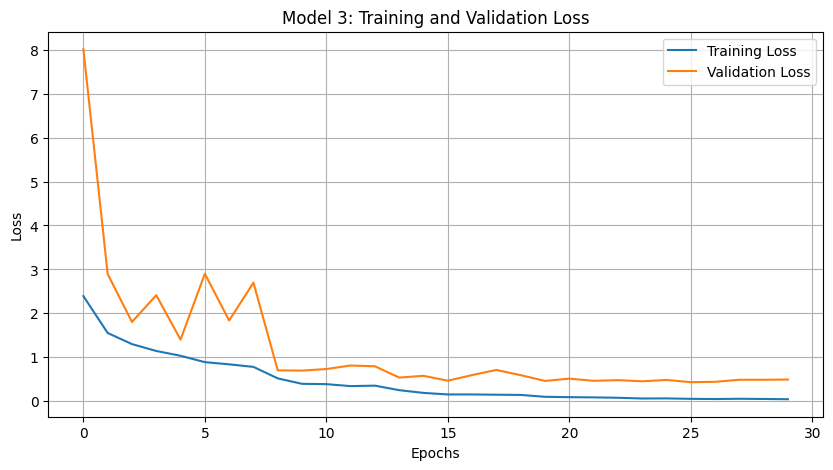

In [14]:
# Plot training and validation loss for Model 3
plt.figure(figsize=(10, 5))
plt.plot(results['InceptionV3'].history['loss'], label='Training Loss')
plt.plot(results['InceptionV3'].history['val_loss'], label='Validation Loss')
plt.title('Model 3: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


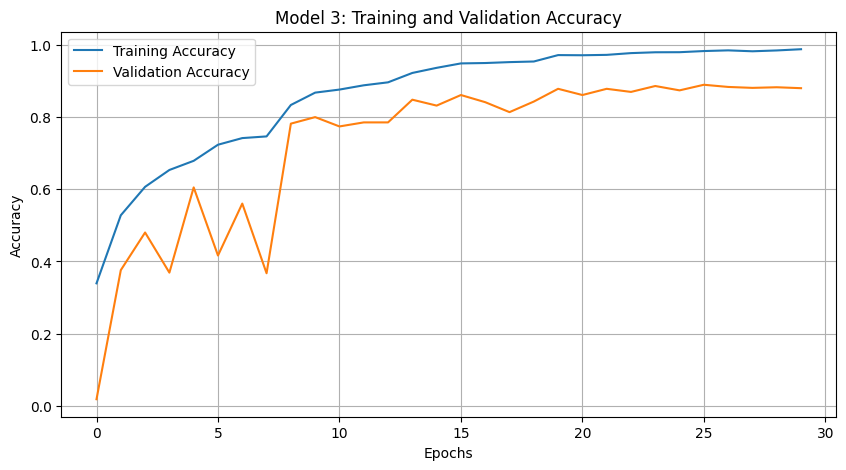

In [15]:
# Plot training and validation accuracy for Model 3
plt.figure(figsize=(10, 5))
plt.plot(results['InceptionV3'].history['accuracy'], label='Training Accuracy')
plt.plot(results['InceptionV3'].history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 3: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


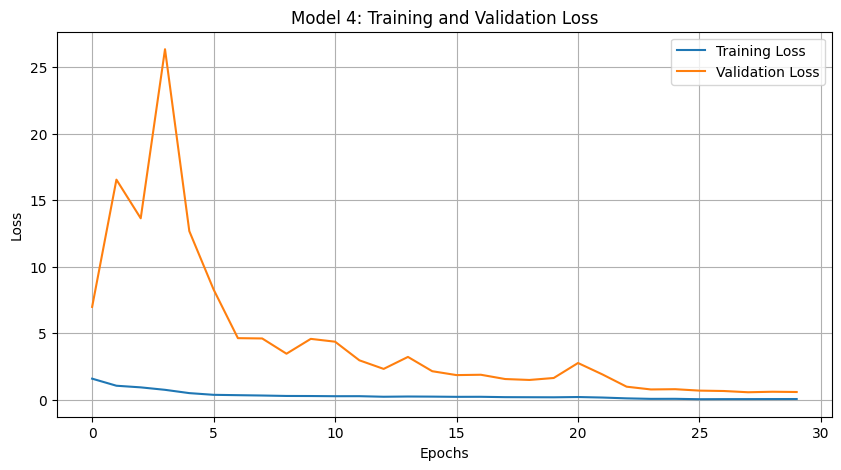

In [16]:
# Plot training and validation loss for Model 4
plt.figure(figsize=(10, 5))
plt.plot(results['MobileNetV2'].history['loss'], label='Training Loss')
plt.plot(results['MobileNetV2'].history['val_loss'], label='Validation Loss')
plt.title('Model 4: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


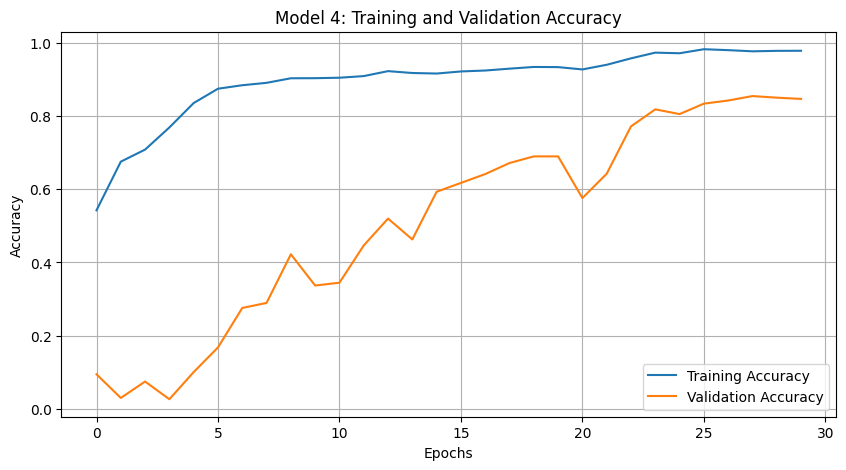

In [17]:
# Plot training and validation accuracy for Model 4
plt.figure(figsize=(10, 5))
plt.plot(results['MobileNetV2'].history['accuracy'], label='Training Accuracy')
plt.plot(results['MobileNetV2'].history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 4: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [18]:
# Display validation accuracy comparison
print("\nValidation Accuracy Comparison:")
for model_name, history in results.items():
    val_acc = max(history.history['val_accuracy'])
    print(f'{model_name}: {val_acc:.2f}') 



Validation Accuracy Comparison:
EfficientNetB0: 0.90
ResNet50: 0.87
InceptionV3: 0.89
MobileNetV2: 0.85


In [19]:
# Load and preprocess test images
def load_and_preprocess_image(img_path, target_size=(224
, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array


In [20]:
# Set up the ImageDataGenerator to get class indices from training data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the mapping of class indices to breed names
index_to_class = {v: k for k, v in train_generator.class_indices.items()}


Found 5890 images belonging to 37 classes.


In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Set up the ImageDataGenerator to get class indices from training data
train_dir ="/kaggle/input/animal-breed-dataset/animal_breed_classification/TRAIN"

# Create an ImageDataGenerator for training data to extract class indices
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the mapping of class indices to breed names
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Step 2: Load and preprocess test images
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Step 3: Predict for each image in the test directory
test_dir = "/kaggle/input/animal-breed-dataset/animal_breed_classification/TEST"
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

predictions = []
for img_path in test_image_paths:
    img_array = load_and_preprocess_image(img_path)
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)[0]
    predictions.append(predicted_class)

# Step 4: Map predictions to breed names
predicted_labels = [index_to_class.get(i, "Unknown") for i in predictions]

# Step 5: Output the predictions
for img_path, label in zip(test_image_paths, predicted_labels):
    print(f"Image: {img_path}, Predicted Breed: {label}")


Found 5890 images belonging to 37 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━

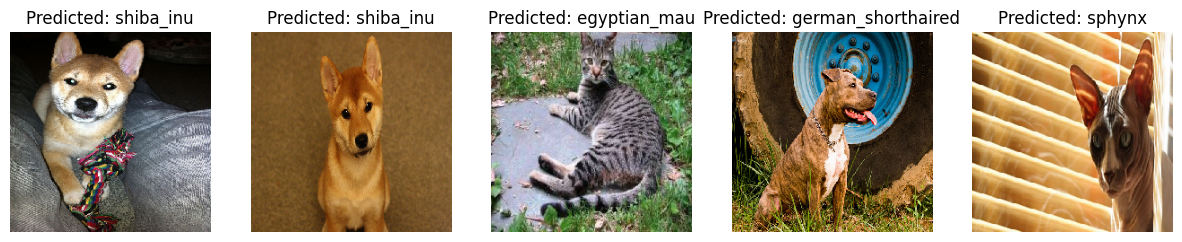

In [22]:
import matplotlib.pyplot as plt
import random

# Step 1.1: Display some predictions
def display_random_predictions(image_paths, predicted_labels, num_images=5):
    # Randomly select `num_images` from the test set
    random_indices = random.sample(range(len(image_paths)), num_images)
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        img_path = image_paths[idx]
        img = image.load_img(img_path, target_size=(224, 224))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_labels[idx]}")
        plt.axis('off')
    plt.show()

# Display predictions for a few random test images
display_random_predictions(test_image_paths, predicted_labels, num_images=5)


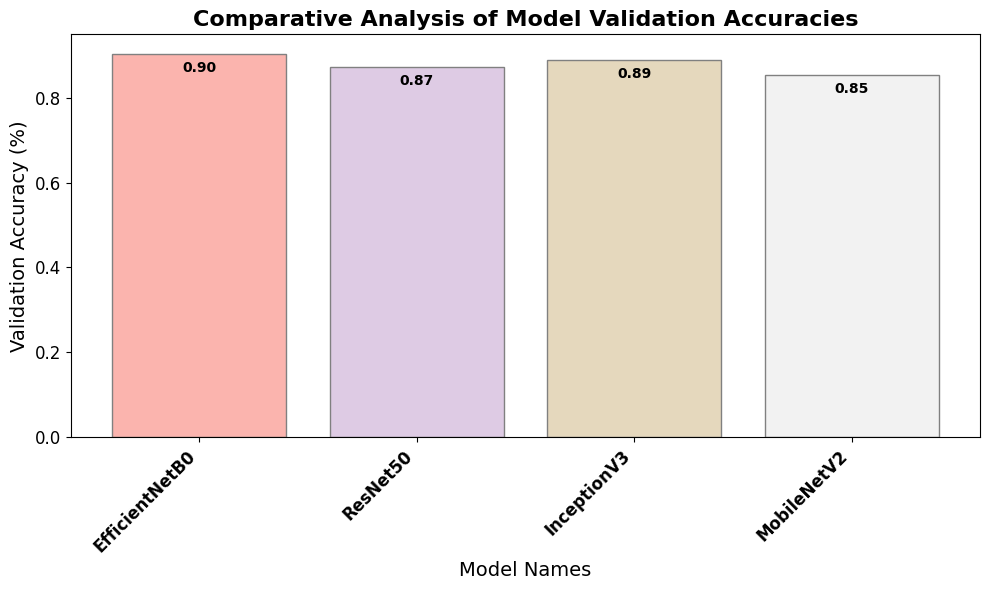

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the validation accuracy values for each model
validation_accuracies = [max(history.history['val_accuracy']) for history in results.values()]
model_names = list(results.keys())

# Set up the bar graph
plt.figure(figsize=(10, 6))
colors = plt.cm.Pastel1(np.linspace(0, 1, len(model_names)))  # Use a pastel colormap for better contrast on text

# Plot bar chart with refined aesthetics
bars = plt.bar(model_names, validation_accuracies, color=colors, edgecolor='gray', linewidth=1)

# Add data labels above each bar
for bar, accuracy in zip(bars, validation_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{accuracy:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Set title and labels with enhanced styling
plt.title('Comparative Analysis of Model Validation Accuracies', fontsize=16, fontweight='bold')
plt.xlabel('Model Names', fontsize=14)
plt.ylabel('Validation Accuracy (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


In [24]:
import os

print(os.listdir('/kaggle/working/'))


['best_model.keras', '.virtual_documents']


In [25]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model('/kaggle/working/best_model.keras')  # Load the model
print("Model loaded successfully.")


Model loaded successfully.


In [26]:
# Save the trained model
model.save('/kaggle/working/best_model.keras')
print("Model saved successfully.")


Model saved successfully.
